In [1]:
import os.path
import sys

import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from six.moves import urllib

ROOT_DIR = os.path.abspath("..")
sys.path.append(ROOT_DIR)

from src.deeplab.model import DeepLabModel
import src.deeplab.visualize as dl_viz
from src.mrcnn import utils
import src.mrcnn.coco as coco
from src.mrcnn.model import MaskRCNN


%matplotlib inline


C:\Users\Admin\anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Admin\anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Admin\anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Admin\anaconda3\envs\mrcnn\lib\site-packages\tensorflow\python\f

# Download models

In [2]:
LOGS_DIR = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = os.path.join(ROOT_DIR, "weights")

# DeepLab
DL_MODEL_PATH = os.path.join(MODEL_DIR, "deeplab_model.tar.gz")
DL_URL = (
    "http://download.tensorflow.org/models/"
    "deeplabv3_mnv2_ade20k_train_2018_12_03.tar.gz"
)

if not os.path.exists(DL_MODEL_PATH):
    print("Downloading DeepLab model...")
    urllib.request.urlretrieve(DL_URL, DL_MODEL_PATH)
    print("Download complete, loading DeepLab model...")

DL_MODEL = DeepLabModel(DL_MODEL_PATH)
print("DeepLab model loaded successfully!")

# MRCNN
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

MRCNN_MODEL_PATH = os.path.join(MODEL_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(MRCNN_MODEL_PATH):
    utils.download_trained_weights(MRCNN_MODEL_PATH)
config = InferenceConfig()
# Create model object in inference mode.
MRCNN_MODEL = MaskRCNN(mode="inference", model_dir=LOGS_DIR, config=config)

# Load weights trained on MS-COCO
MRCNN_MODEL.load_weights(MRCNN_MODEL_PATH, by_name=True)

DeepLab model loaded successfully!
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


# Set up labels and colors

In [3]:
DL_LABEL_NAMES = np.asarray([
    "others", "wall", "building", "sky", "floor", "tree", "ceiling", "road",
    "bed", "windowpane", "grass", "cabinet", "sidewalk", "person", "earth",
    "door", "table", "mountain", "plant", "curtain", "chair", "car", "water",
    "painting", "sofa", "shelf", "house", "sea", "mirror", "rug", "field",
    "armchair", "seat", "fence", "desk", "rock", "wardrobe", "lamp", "bathtub",
    "railing", "cushion", "base", "box", "column", "signboard", "chest",
    "counter", "sand", "sink", "skyscraper", "fireplace", "refrigerator",
    "grandstand", "path", "stairs", "runway", "case", "pool", "pillow",
    "screen", "stairway", "river", "bridge", "bookcase", "blind", "coffee",
    "toilet", "flower", "book", "hill", "bench", "countertop", "stove", "palm",
    "kitchen", "computer", "swivel", "boat", "bar", "arcade", "hovel", "bus",
    "towel", "light", "truck", "tower", "chandelier", "awning", "streetlight",
    "booth", "television", "airplane", "dirt", "apparel", "pole", "land",
    "bannister", "escalator", "ottoman", "bottle", "buffet", "poster", "stage",
    "van", "ship", "fountain", "conveyer", "canopy", "washer", "plaything",
    "swimming", "stool", "barrel", "basket", "waterfall", "tent", "bag",
    "minibike", "cradle", "oven", "ball", "food", "step", "tank", "trade",
    "microwave", "pot", "animal", "bicycle", "lake", "dishwasher", "screen",
    "blanket", "sculpture", "hood", "sconce", "vase", "traffic", "tray",
    "ashcan", "fan", "pier", "crt", "plate", "monitor", "bulletin", "shower",
    "radiator", "glass", "clock", "flag"
])
DL_LABEL_MAP = np.arange(len(DL_LABEL_NAMES)).reshape(len(DL_LABEL_NAMES), 1)
DL_COLOR_MAP = dl_viz.label_to_color_image(DL_LABEL_MAP)

MRCNN_LABEL_NAMES = [
    "BG", "person", "bicycle", "car", "motorcycle", "airplane",
    "bus", "train", "truck", "boat", "traffic light",
    "fire hydrant", "stop sign", "parking meter", "bench", "bird",
    "cat", "dog", "horse", "sheep", "cow", "elephant", "bear",
    "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie",
    "suitcase", "frisbee", "skis", "snowboard", "sports ball",
    "kite", "baseball bat", "baseball glove", "skateboard",
    "surfboard", "tennis racket", "bottle", "wine glass", "cup",
    "fork", "knife", "spoon", "bowl", "banana", "apple",
    "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza",
    "donut", "cake", "chair", "couch", "potted plant", "bed",
    "dining table", "toilet", "tv", "laptop", "mouse", "remote",
    "keyboard", "cell phone", "microwave", "oven", "toaster",
    "sink", "refrigerator", "book", "clock", "vase", "scissors",
    "teddy bear", "hair drier", "toothbrush"
]

# Process video

In [4]:
VIDEO_PATH = os.path.join(ROOT_DIR, "videos", "People_sample_2.mp4")

In [5]:
cap = cv2.VideoCapture(VIDEO_PATH)
fps = cap.get(cv2.CAP_PROP_FPS)
output_path = f"{os.path.splitext(VIDEO_PATH)[0]}_processed.avi"

vid_writer = cv2.VideoWriter(
    output_path,
    cv2.VideoWriter_fourcc("M", "J", "P", "G"),
    fps,
    (
        round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)),
    ),
)

In [6]:
has_frame, frame = cap.read()
_, seg_map = DL_MODEL.run(Image.fromarray(frame[:, :, ::-1]))
seg_map = cv2.resize(
    seg_map, frame.shape[:-1][::-1], interpolation=cv2.INTER_NEAREST
)

In [7]:
from matplotlib import gridspec

def display_segmentation(image, seg_map):
    """Visualizes input image, segmentation map and overlay view."""
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 2, width_ratios=[8, 1])

    seg_image = dl_viz.label_to_color_image(seg_map).astype(np.uint8)
    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis("off")
    plt.title("segmentation overlay")

    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[1])
    plt.imshow(
        DL_COLOR_MAP[unique_labels].astype(np.uint8),
        interpolation="nearest",
    )
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), DL_LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0)
    plt.grid("off")
    plt.show()

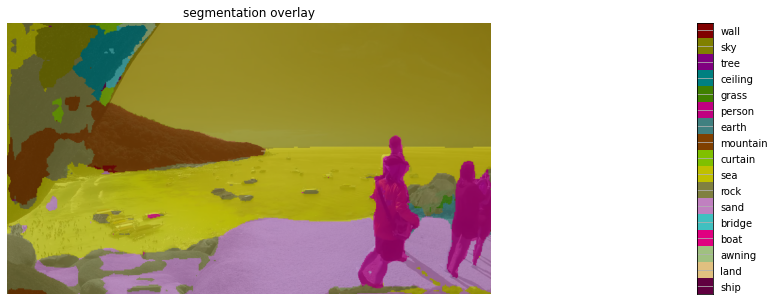

In [8]:
display_segmentation(frame, seg_map)

In [9]:
def apply_mask(image, mask, color, alpha=0.5):
    """apply mask to image"""
    for n, c in enumerate(color):
        image[:, :, n] = np.where(
            mask == 1,
            image[:, :, n] * (1 - alpha) + alpha * c,
            image[:, :, n]
        )
    return image


# based on https://github.com/matterport/Mask_RCNN/blob/master/mrcnn/visualize.py
# and https://github.com/markjay4k/Mask-RCNN-series/blob/887404d990695a7bf7f180e3ffaee939fbd9a1cf/visualize_cv.py
def display_instances(image, boxes, masks, class_ids, class_names, scores=None):
    assert boxes.shape[0] == masks.shape[-1] == class_ids.shape[0]
    
    N = boxes.shape[0]
    c = (0, 255, 0)
    counter = 0

    for i in range(N):
        if not np.any(boxes[i]):
            continue
        
        y1, x1, y2, x2 = boxes[i]
        label = class_names[class_ids[i]]
        if label != "person":
            continue
        score = scores[i] if scores is not None else None
        caption = "{} {:.3f}".format(label, score) if score else label
        counter += 1

        # Mask
        mask = masks[:, :, i]
        image = apply_mask(image, mask, c)
        image = cv2.rectangle(image, (x1, y1), (x2, y2), c, 2)
        image = cv2.putText(image, caption, (x1, y1), cv2.FONT_HERSHEY_COMPLEX, 0.7, c, 2)

    image = cv2.putText(image, str(counter), (0, 20), cv2.FONT_HERSHEY_COMPLEX, 0.7, c, 2)
    return image

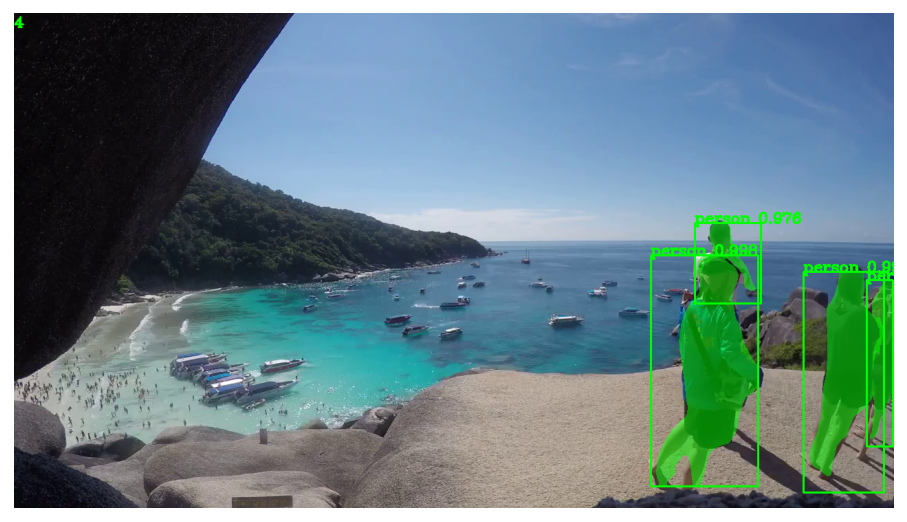

In [10]:
# has_frame, frame = cap.read()
results = MRCNN_MODEL.detect([frame[:, :, ::-1]])
r = results[0]
frame = display_instances(
    frame, r["rois"], r["masks"], r["class_ids"], MRCNN_LABEL_NAMES, r["scores"]
)

_, ax = plt.subplots(1, figsize=(16, 16))
height, width = frame.shape[:2]
ax.set_ylim(height + 10, -10)
ax.set_xlim(-10, width + 10)
ax.axis("off")
ax.imshow(frame[:, :, ::-1])
